# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
import math
import pickle

# -------------------------------------------------------------
# Question1 : Face Detection
# -------------------------------------------------------------

The goal of the Viola Jones Algorithm is - Given an image(this algorithm works on grayscale image), the algorithm looks at many smaller subregions and tries to find a face by looking for specific features in each subregion.

Viola Jones is different from a CNN since a CNN is a single classifier which looks at a full image and applies matrix operations to arrive at a classification, Viola-Jones takes an ensemble approach. What that means is that Viola-Jones uses many different classifiers, each looking at a different portion of the image. Each individual classifier is weaker (less accurate, produces more false positives, etc) than the final classifier because it is taking in less information.

The Viola Jones algorithm has four main steps:
1. Selecting Haar-like features
2. Creating an integral image
3. Running AdaBoost training
4. Creating classifier cascades

## Load and Prepare Dataset

Of the many available datasets for face detection, the following datasets were used for training the VJ algorithm. One limitation of the training is that, the non-face dataset is not extremely diverse, further, the compute resources allowed training only a subset of images and hence if a *larger* and *more diverse* dataset is used, the accuracy and precision of the algorithm can be improved. The datasets are :

* Face dataset 1 : [FDDB Dataset](http://vis-www.cs.umass.edu/fddb/)
* Non face dataset 1 : [CIFAR-10](https://www.kaggle.com/c/cifar-10/data?select=train.7z) 
* Face and Non- Face dataset 2: [MIT Learning and Inference in Vision 6.889](http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz)

In [2]:
# face_train_data_path = "../dataset/curated/fddb_faces_train.pkl"
# face_test_data_path = "../dataset/curated/fddb_faces_test.pkl"
# face_test_data_cropped_path = "../dataset/curated/fddb_faces_test_cropped.pkl"
# nonface_train_data_path = "../dataset/curated/cifar_nonfaces_train.pkl"
# nonface_test_data_path = "../dataset/curated/cifar_nonfaces_test.pkl"

face_train_data_path = "../dataset/curated/data_train_faces.pkl"
face_test_data_path = "../dataset/curated/fddb_faces_test.pkl"
face_test_data_cropped_path = "../dataset/curated/data_test_faces.pkl"
nonface_train_data_path = "../dataset/curated/data_train_nonfaces.pkl"
nonface_test_data_path = "../dataset/curated/data_test_nonfaces.pkl"

In [3]:
def get_images_and_labels(filepath):
    
    with open(filepath, 'rb') as f:
        return np.asarray(pickle.load(f))

In [4]:
f_train_data = get_images_and_labels(face_train_data_path)

In [5]:
nf_train_data = get_images_and_labels(nonface_train_data_path)

In [65]:
f_test_data = get_images_and_labels(face_test_data_path)

In [7]:
nf_test_data = get_images_and_labels(nonface_test_data_path)

In [8]:
f_test_data_cropped = get_images_and_labels(face_test_data_cropped_path)

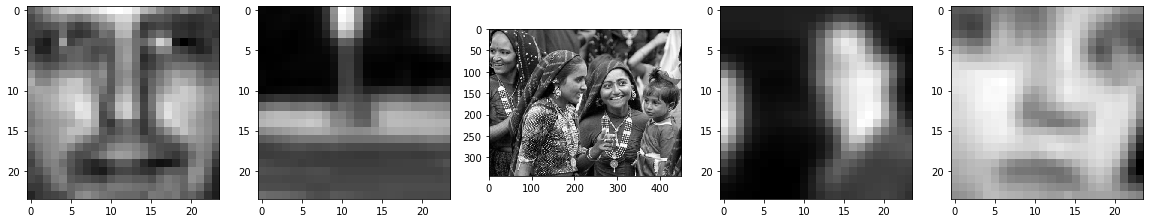

In [9]:
fig, ax = plt.subplots(1,5, figsize = (20,12))

ax[0].imshow(f_train_data[0][0], cmap='gray')
ax[1].imshow(nf_train_data[0][0], cmap='gray')
ax[2].imshow(f_test_data[0][0], cmap='gray')
ax[3].imshow(nf_test_data[0][0], cmap='gray')
ax[4].imshow(f_test_data_cropped[0][0], cmap='gray')

In [10]:
print("Face Train data : ", f_train_data.shape)
print("Non face train data : ", nf_train_data.shape)
print("Face test data : ", f_test_data.shape)
print("Nonface test data : ", nf_test_data.shape)
print("Face test data cropped: ", f_test_data_cropped.shape)

Face Train data :  (2429, 2)
Non face train data :  (4548, 2)
Face test data :  (280, 2)
Nonface test data :  (23573, 2)
Face test data cropped:  (472, 2)


In [11]:
#merge and shuffle train and test data
f_train_data = f_train_data[np.random.choice(f_train_data.shape[0], size = 750, replace=False)]
nf_train_data = nf_train_data[np.random.choice(nf_train_data.shape[0], size = 750, replace=False)]
train_data = np.concatenate((f_train_data, nf_train_data), axis=0)
np.random.shuffle(train_data)

#subsample few images 
nf_test_data = nf_test_data[np.random.choice(nf_test_data.shape[0], size=250, replace=False)]
# f_test_data = f_test_data[np.random.choice(f_test_data.shape[0], size=250, replace=False)]
# test_data = np.concatenate((f_test_data, nf_test_data), axis=0)

f_test_data_cropped = f_test_data_cropped[np.random.choice(f_test_data_cropped.shape[0], size=250, replace=False)]
test_data = np.concatenate((f_test_data_cropped, nf_test_data), axis=0)

np.random.shuffle(test_data)


print("Final train data : ", train_data.shape)
print("Final test data : ", test_data.shape)

Final train data :  (1500, 2)
Final test data :  (500, 2)


## a) Harr Feature extraction

Haar-like features are digital image features used in object recognition. All human faces share some universal properties of the human face like the eyes region is darker than its neighbour pixels, and the nose region is brighter than the eye region.

There are 3 types of Haar-like features that Viola and Jones identified in their research:
1. Edge features
2. Line-features
3. Four-sided features

Edge features and Line features are useful for detecting *edges and lines respectively*. The four-sided features are used for finding *diagonal features*.

The value of the feature is calculated as a single number: the sum of pixel values in the black area minus the sum of pixel values in the white area. The value is **zero for a plain surface** in which all the pixels have the same value, and thus, provide no useful information. 

Since our faces are of complex shapes with darker and brighter spots, a Haar-like feature gives you a large number when the areas in the black and white rectangles are very different. Using this value, we get a piece of valid information out of the image. It is easy to see that even for small images, there are a lot of features (over 160,000 for a 24 x 24 image).


To compute the sum of pixels in any region with top left coordinates : **(tlx, tly)** and botton right coordinates as **(brx, bry)** we can use the following formula on the *integral image*

$$val = im(brx,bry) + im(tlx,tly) - im(brx,tly) - im(tlx,bry)$$

In [12]:
class HaarFeature():
    
    def __init__(self, tlx, tly, brx, bry):
        
        self.tlx = tlx
        self.tly = tly
        self.brx = brx
        self.bry = bry
        
    def compute_feature_value(self, int_im):
        val = int_im[self.brx][self.bry] + int_im[self.tlx][self.tly] - int_im[self.brx][self.tly] - int_im[self.tlx][self.bry]
        return val

In [13]:
def get_haar_feature_value(im, add, sub):
    val = 0
    for region in add:
        val += region.compute_feature_value(im)
    for region in sub:
        val -= region.compute_feature_value(im)

    return val

## b) Integral Image Computation

An integral image is used as a quick and efficient way to calculate the sum of pixel values in an image or rectangular part of an image. In an integral image, the value of each point is the sum of all pixels above and to the left, including the target pixel. The formula to obtain the integral image is :

$$s(x,y) = s(x, y-1) + ii(x,y)$$
$$ii(x,y) = ii(x-1,y) + s(x,y)$$

This intermediate representation of integral images is essential because it allows for fast calculation of rectangular region. Since the process of extracting Haar-like features involves calculating the sum of dark/light rectangular regions, the introduction of Integral Images greatly cuts down the time needed to complete this task.

In [14]:
def compute_integral_image(im):

    h,w = im.shape[0], im.shape[1]
    int_im = np.zeros((h, w))
    sum_im = np.zeros((h, w))
        
    for i in range(h):
        for j in range(w):
            
            #THIS IS WRONG stupid behaviour
            #sum_im[i][j] = sum_im[i][j-1] + im[i-1][j-1]
            #int_im[i][j] = int_im[i-1][j] + sum_im[i][j]
            
            sum_im[i][j] = sum_im[i-1][j] + im[i][j] if i-1 >=0 else im[i][j]
            int_im[i][j] = int_im[i][j-1] + sum_im[i][j] if j-1 >=0 else sum_im[i][j]
    
    return int_im
    

In [15]:
tttt = np.array([[1,2,3,4],[5,6,7,8],[1,1,1,1],[2,3,4,5]])
compute_integral_image(tttt)

array([[ 1.,  3.,  6., 10.],
       [ 6., 14., 24., 36.],
       [ 7., 16., 27., 40.],
       [ 9., 21., 36., 54.]])

## c) Adaboost Training of Classifiers

Once the haar-like features are computed for all the different train images, the next step is to train the **weak classifiers**. The only hyper-parameter which the algorithm uses is the number of features ie :  weak classifiers.

For training, Viola-Jones uses a variant of Adaboost. The general idea of boosting is for each subsequent weak classifier to correct the mistakes of the previous classifier. To do this, it assigns a weight to each training example, trains the classifiers, chooses the best classifier, and updates the weights according to the error of the classifier. Incorrectly labeled examples will get larger weights so they are correctly classified by the next classifier chosen.

The main reason for choosing Adaboost is that the number of features that are present in the 24×24 detector window is nearly 160,000, but only a few of these features are important to identify a face. So we use the AdaBoost algorithm to **identify the best features in the 160,000 features**. 

In every iteration, the best weak classifier out of the set of all weak classifier is chosen and stored. Once all the weak classifiers are chosen, the strong classifier is built. With each best weak classifier, and its error, there exist $\alpha$ values also that are stored ($\alpha = log \frac{1}{\beta_t}$ where $\beta$ is got from the accuracy of each classifier. 

Finally the strong classifier can be computed as : 

$$ h(x) = 
  \begin{cases}
                                   1 & \text{if $\sum_{t=1}^{T}{\alpha_t h_t(x)} >= \frac{1}{2}\sum_{t=1}^{T}{\alpha_t}$} \\
                                   0 & \text{otherwise} \\
  \end{cases}
$$

In [16]:
class ViolaJones():
    
    def __init__(self, num_wc, training_data):
        
        self.num_wc = num_wc
        self.train_images = [compute_integral_image(x[0]) for x in training_data]        
        self.train_labels = [x[1] for x in training_data]  # 0 for negative samples (no face) 1 for positive samples
        
        self.alphas = []
        self.weak_clfs = []
    
    '''
    Functions to save and load the classifiers into and from
    pickle files that can be used for later use for face 
    detection task and evaluation of the classifier
    '''
    def save(self, filename):
        with open(filename+".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename+".pkl", 'rb') as f:
            return pickle.load(f)
    '''
    Function to create all the 5 haar features that is : edge, line, 4-rect
    Each feature is represented by a pair of lists - the set of rectangles that 
    contribute positively to the feature value and the set of rectangles that 
    contribute negatively. All the features are then returned as a list of features
    '''    
    def get_haar_features(self, h, w):        
                    
        self.haar_features = []

        for i in range(1, h+1):
            for j in range(1, w+1):

                for x in range(h):

                    if x+i >= h:
                        break

                    for y in range(w):

                        if y+j >= w:
                            break

                        #get edge features horizontal
                        if y+2*j < w:
                            add = HaarFeature(x, y+j, x+i, y+2*j)
                            sub = HaarFeature(x, y, x+i, y+j)
                            self.haar_features.append([[add], [sub]])

                        #get edge features vertical
                        if x+2*i < h:
                            #add = HaarFeature(x+i, y, x+2*i, y+j)
                            #sub = HaarFeature(x,y, x+i, y+j)
                            add = HaarFeature(x,y, x+i, y+j)
                            sub = HaarFeature(x+i, y, x+2*i, y+j)
                            self.haar_features.append([[add],[sub]])


                        #get line feature horizontal
                        if y+3*j < w:
                            add = HaarFeature(x, y+j, x+i, y+2*j)
                            subl = HaarFeature(x,y,x+i, y+j)
                            subr = HaarFeature(x, y+2*j, x+i, y+3*j)
                            self.haar_features.append([[add],[subl, subr]])

                        #get line features vertical 
                        if x+3*i < h:
                            add =  HaarFeature( x+i, y, x+2*i, y+j)
                            subt =  HaarFeature(x,y,x+i, y+j)
                            subb =  HaarFeature(x+2*i, y, x+3*i, y+j)
                            self.haar_features.append([[add],[subt, subb]])

                        #get four rectangle features
                        if x+2*i < h and y+2*j < w:

                            addr = HaarFeature(x, y+j, x+i, y+2*j)
                            addl = HaarFeature(x+i, y,x+2*i, y+j)
                            subl = HaarFeature(x,y,x+i, y+j)
                            subr = HaarFeature(x+i, y+j, x+2*i, y+2*j)
                            self.haar_features.append([[addr, addl],[subl, subr]])

        self.haar_features = np.asarray(self.haar_features)
                  
    '''
    Function to apply the haar features on the train images and
    get the values of the train features for the train dataset. For each image, 
    a feature vector of length len(features) is created by applying each of the 
    many haar features on the entire image. Final dimensions of the train_features
    is len(features) x len(train_images)
    '''
    def process_haar_features(self):
        
        self.train_features = np.zeros((len(self.haar_features),len(self.train_images)))
        for i, im in tqdm.tqdm(enumerate(self.train_images)):
            
            for j, feature in enumerate(self.haar_features):
                self.train_features[j][i] = get_haar_feature_value(im, feature[0], feature[1])
    
    '''
    The strong classifer that is built using the multiple best weak
    classifiers that are selected over the iterations of the training
    for the weak classifiers. It takes an image and then computes whether
    or not to classify it as 1 or 0 based on the formula mentioned in Table1.
    in the original viola jones paper
    '''
    def strong_classify(self, image):
        int_im = compute_integral_image(image)
        wc_lin_comb = sum([alpha * clf.weak_classify(int_im) for alpha, clf in zip(self.alphas, self.weak_clfs)])
        
        #print(len(self.weak_clfs))
        
        return 1 if wc_lin_comb >= 0.5 * sum(self.alphas) else 0
    
    
    '''
    Function to train the weights per weak classifier. Loops for num_wc 
    iterations to select num_wc weak classfiers for the strong 
    classification process. The steps followed are exactly the adaboost
    training steps as mentioned in Table1. of the paper
    '''
    def train_weights(self):
        
        '''
        STEP1 : Initialize weights. Compute the several haar
        features, and apply the haar features to each of the training
        images to obtain the feature maps of each image. 
        '''
        m = self.train_labels.count(0)
        l = self.train_labels.count(1)
        self.weights = []
        print("neg count", m, "pos count", l)
        
        for label in tqdm.tqdm(self.train_labels):
            if label == 0 : #negative sample
                self.weights.append(1/(2*m))
            elif label == 1: #positive samples
                self.weights.append(1/(2*l))
                
        #get all the haar features for each weak classifier prepare the feature maps
        self.get_haar_features(self.train_images[0].shape[0], self.train_images[0].shape[1])
        self.process_haar_features()
        
        #select only the best features : shape(num features, len train)
        indices = SelectPercentile(f_classif, percentile=10).fit(self.train_features.T, self.train_labels).get_support(indices=True)
        self.haar_features = self.haar_features[indices]
        self.train_features = self.train_features[indices]
        print("Selected potential features", len(self.haar_features), len(self.train_features))
        
        '''
        STEP2 : start training T weak classifiers to then build a strong classifier. 
        Each iter selects one best classifier
        '''
        for c in tqdm.tqdm(range(self.num_wc)):
            
            #Step 2.1 : Normalize the weights
            self.weights = self.weights / np.linalg.norm(self.weights)
            
            #Step 2.2 : train the weak classifiers 
            #Step 2.3 : select the one with the lest error
            twc = TrainWeakClassifiers(self.train_features, self.haar_features, self.train_images, self.train_labels, self.weights)
            best_classfier, best_error, ei = twc.train_select_weak_classifier()
            
            #print("best err ", best_error)
            #print("best ei's", ei)
            
            #Step 2.4 : Update the weights 
            beta = best_error / (1.0 - best_error)
            for i,e in enumerate(ei):
                self.weights[i] = self.weights[i] * (beta ** (1 - e))
            
            #Step 2.5 accumulate the alphas and classifiers that
            #are best chosen for this iteration
            alpha = math.log(1.0/beta)
            self.alphas.append(alpha)
            self.weak_clfs.append(best_classfier)
            #print("Chose classifier: %s with accuracy: %f and alpha: %f" % (str(best_classfier), len(ei) - sum(ei), alpha))
            

In [17]:
class WeakClassifier():
    def __init__(self, positive_regions, negative_regions, threshold, polarity):
        self.positive_regions = positive_regions
        self.negative_regions = negative_regions
        self.threshold = threshold
        self.polarity = polarity
    
    def weak_classify(self, x):
        
        val = get_haar_feature_value(x, self.positive_regions, self.negative_regions)
        return 1 if self.polarity * val < self.polarity * self.threshold else 0
    
    def __str__(self):
        return "Weak Clf (threshold=%d, polarity=%d, %s, %s" % (self.threshold, self.polarity, str(self.positive_regions), str(self.negative_regions))
    
class TrainWeakClassifiers():
    
    def __init__(self, train_features, haar_features, train_images, labels, weights):
        self.train_features = train_features
        self.haar_features = haar_features
        self.train_images = train_images
        self.labels = labels
        self.weights = weights
    
    def select_best_weak_classifier(self, classifiers):
        
        best_clf, best_error, best_accuracy = None, float('inf'), None
        for clf in (classifiers):
            error, accuracy = 0, []
            for im, label, w in zip(self.train_images, self.labels, self.weights):
                correctness = abs(clf.weak_classify(im) - label)
                accuracy.append(correctness)
                error += w * correctness
            error = error / len(self.train_images)
            if error < best_error:
                best_clf, best_error, best_accuracy = clf, error, accuracy
        return best_clf, best_error, best_accuracy
    
    '''
    Function to train a set of weak classifiers. For each classifer
    the same feature for each image is considered. Now we wish to 
    minimize the weighted sum of the error classes. That is the min
    of the (nonface < threshold and face > threshold) when criteria is < thresh
    and (face< thresh and nonface > thresh) when criteria is > thresh
    '''
    def train_select_weak_classifier(self):
        
        total_face, total_nonface = 0, 0
        
        for w, label in zip(self.weights, self.labels):
            if label == 1:
                total_face += w
            else:
                total_nonface += w
        
        classifiers = []
        total_features = self.train_features.shape[0]
        
        for index, feature in (enumerate(self.train_features)):

            applied_feature = sorted(zip(self.weights, feature , self.labels), key=lambda x: x[1])
                        
            face_seen, nonface_seen = 0, 0
            face_weights, nonface_weights = 0, 0
            min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
            for w, f, label in applied_feature:
                error = min(nonface_weights + total_face - face_weights, face_weights + total_nonface - nonface_weights)
                if error < min_error:
                    min_error = error
                    best_feature = self.haar_features[index]
                    best_threshold = f
                    best_polarity = 1 if face_seen > nonface_seen else -1

                if label == 1:
                    face_seen += 1
                    face_weights += w
                else:
                    nonface_seen += 1
                    nonface_weights += w
        
            
            clf = WeakClassifier(best_feature[0], best_feature[1], best_threshold, best_polarity)
            classifiers.append(clf)

            

        return self.select_best_weak_classifier(classifiers)

## Training the Classifiers

In [18]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [19]:
def train_face_detector(num_wc, train_data):
    classifier = ViolaJones(num_wc, train_data)
    classifier.train_weights()
    classifier.save("./models/classifier_wc"+str(num_wc))
    
    return classifier

In [20]:
vj_classifier = train_face_detector(50, train_data)

100%|██████████| 1500/1500 [00:00<00:00, 2335358.57it/s]

neg count 750 pos count 750



1500it [19:56,  1.25it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

Selected potential features 13666 13666


100%|██████████| 50/50 [2:38:18<00:00, 189.97s/it]  


## Creating the Face Detector

In [285]:
class FaceDetector():
    
    def __init__(self, model):
        
        with open(model, 'rb') as f:
            self.detector = pickle.load(f)

            
        self.faces = []
        self.nonfaces = []
        self.predictions = []
        self.labels = []
            
    def get_accuracy(self):
        
        print("num predictions = ", len(self.predictions))
        print("num labels = ", len(self.labels))
        
        pred_pos = 0
        total_pos = sum(self.labels)
        tp, tn, fp, fn = 0,0,0,0
                
        for i, pred in enumerate(self.predictions):
                        
            #if true negative
            if self.labels[i] == 0 and pred == 0:
                tn += 1
            
            #if false positive
            if self.labels[i] == 0 and pred > 0: 
                fp += pred
            
            #if false negative
            if self.labels[i] > 0 and pred == 0:
                fn += self.labels[i]
            
            #if both greater than 0
            if self.labels[i] > 0 and pred > 0:
                if self.labels[i] > pred:
                    tp += pred
                    fn += self.labels[i] - pred
                else:
                    tp += self.labels[i]
                    fp += pred - self.labels[i]
        
        print("tp = ",tp, "tn = ", tn, "fp = ", fp, "fn = ", fn)
        acc = (tp+tn)/len(self.labels)*100
        
        if tp == 0 and fp == 0:
            prec = 100
        else:
            prec = tp/(tp+fp)*100
        if tp == 0 and fn == 0:
            recall = 100
        else:
            recall = tp/(tp+fn)*100
        
        print ("\n------------------------------------")
        print("Accuracy = ", acc)
        print("Precision = ", prec)
        print("Recall = ", recall) 
        print ("--------------------------------------\n")
        
            
    def basic_detect(self, images):
        
        self.faces = []
        self.nonfaces = []
        self.predictions = []       
        self.images = images[:, 0]
        self.labels = images[:, 1]
                
        for im in tqdm.tqdm(self.images):
            
            im = cv2.resize(im, (24,24))
            pred = self.detector.strong_classify(im)
            
            if pred == 1:
                self.faces.append(pred)
            else:
                self.nonfaces.append(pred)
                
            self.predictions.append(pred)
            
        self.get_accuracy()
        
    
    
    def draw_detected_bb(self, anno, im):
        
        bb_im = np.copy(im)
        for a in anno:
            
            i = a[0]
            j = a[1]
            win = a[2]

            bb_im = cv2.rectangle(bb_im, (j, i), (j+win, i+win), self.color, 2)
            
        return bb_im
        
    
    def detect(self, img, label, window):
        
        #im = cv2.resize(im, (rh, rw))
        self.label = label
        self.pred_faces = 0
        self.pred_anno = []
        h, w = img.shape[0], img.shape[1]
        
        #convert to grey scale if not grey
        if len(img.shape) == 3:
            self.color = (0,255,0)
            im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            self.color= (255,0,0)
            im = np.copy(img)
        
        for i in tqdm.tqdm(range(0,h, 10)):
            for j in range(0, w, 10):
                
                wind = window
                
                while(wind <= 10*window):

                    if i+wind > h or j + wind > w:
                        wind = 2*wind
                        continue
                    
                    patch1 = im[i:i+wind , j:j+wind]
                    patch = cv2.resize(patch1, (24,24))                
                    face = self.detector.strong_classify(patch)
                    
                    if face:
                        
                        #print(face, i,j, wind)
                        #print(i,i+wind, j, j+wind)
                        #print(im.shape, patch1.shape, patch.shape)
                        #plt.imshow(im[i:i+wind + j:j+wind])
                        #plt.imshow(patch)
                        #return 0,0
                        
                        self.pred_faces += 1
                        self.pred_anno.append([i,j,wind])
                        
                    wind = 2*wind
        
        detected_image = self.draw_detected_bb(self.pred_anno, img)        
        return (detected_image, im), self.pred_faces, np.asarray(self.pred_anno)
                
            

In [286]:
detector = FaceDetector("./models/new_classifier_wc50.pkl")

In [229]:
# small = np.asarray([[f_test_data[0][0][0:50, 400:450],0]])
detector.basic_detect(train_data)

100%|██████████| 1500/1500 [00:02<00:00, 657.25it/s]

num predictions =  1500
num labels =  1500
tp =  724 tn =  724 fp =  26 fn =  26

------------------------------------
Accuracy =  96.53333333333333
Precision =  96.53333333333333
Recall =  96.53333333333333
--------------------------------------



In [27]:
detector.basic_detect(test_data)

100%|██████████| 500/500 [00:00<00:00, 675.10it/s]

num predictions =  500
num labels =  500
tp =  71 tn =  243 fp =  7 fn =  179

------------------------------------
Accuracy =  62.8
Precision =  91.02564102564102
Recall =  28.4
--------------------------------------



In [889]:
# randdd = np.random.randint(len(f_test_data))
# print("ind", randdd)
# plt.imshow(f_test_data[randdd][0], cmap='gray')
# print(f_test_data[randdd][1])

# Tests and Results

From the above tests and results we can see that the detector trained usign the viola jones algorithm performs very well on the train data, and does fairly well on the test data. The accuracies and other performance statistics are tabulated as below : 


| Dataset   |      Accuracy      | Precision | Recall |
|----------|:-------------:|------:| -------:|
| Train |  96.53 | 96.53 | 96.53|
| Test |    62.8   |  91.02 | 28.4 |


In [287]:
def plot_results(orig, detec):
        
    fig, ax = plt.subplots(1,2, figsize = (12,15))

    ax[0].imshow(orig, cmap='gray')
#     ax[0].axis('off')
    ax[0].set_title("Original Image")

    ax[1].imshow(detec, cmap='gray')
#     ax[1].axis('off')
    ax[1].set_title("Detected Faces")
    

In [288]:
test_im_1 = np.copy(f_test_data[45])
test_im_1[0] = cv2.resize(test_im_1[0], (140,140))
detected_test_im_1, num_test_im_1, anno_test_im_1 = detector.detect(test_im_1[0], test_im_1[1], 24)

100%|██████████| 14/14 [00:00<00:00, 34.85it/s]


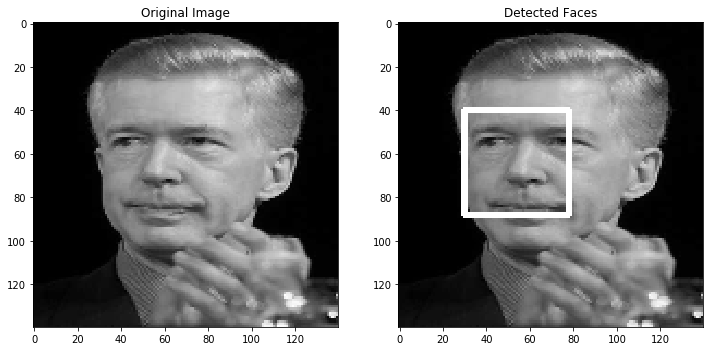

In [289]:
plot_results(test_im_1[0], detected_test_im_1[0])

In [372]:
test_im_2 = np.copy(f_test_data[130])
test_im_2[0] = cv2.resize(test_im_2[0], (200,200))
detected_test_im_2, num_test_im_2, anno_test_im_2 = detector.detect(test_im_2[0], test_im_2[1], 24)

100%|██████████| 20/20 [00:01<00:00, 18.95it/s]


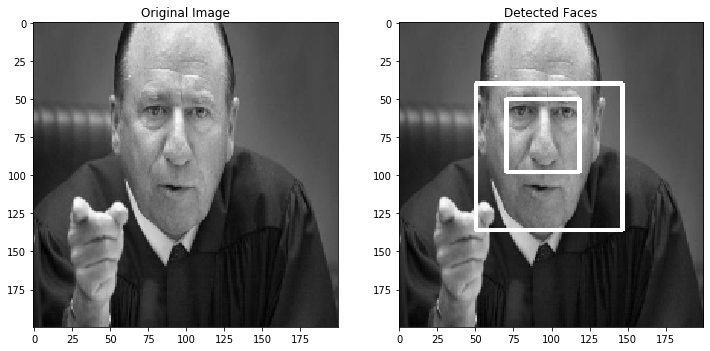

In [373]:
plot_results(test_im_2[0], detected_test_im_2[0])

In [621]:
test_im_6 = np.copy(f_test_data[219])  
test_im_6[0] = cv2.resize(test_im_6[0], (120,120))
detected_test_im_6, num_test_im_6, anno_test_im_6 = detector.detect(test_im_6[0], test_im_6[1], 24)

100%|██████████| 12/12 [00:00<00:00, 46.12it/s]


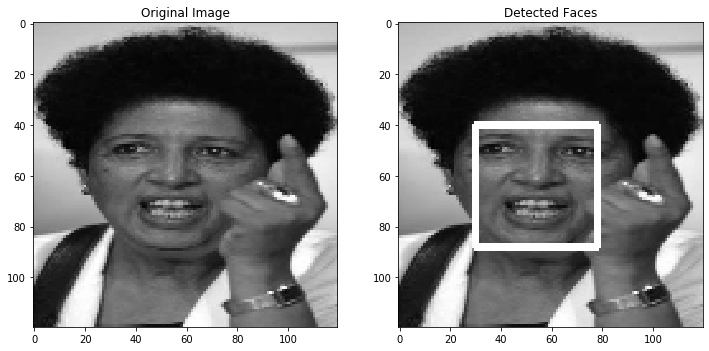

In [622]:
plot_results(test_im_6[0], detected_test_im_6[0])

In [452]:
test_im_3 = np.copy(f_test_data[25])
test_im_3[0] = cv2.resize(test_im_3[0], (220,220))
detected_test_im_3, num_test_im_3, anno_test_im_3 = detector.detect(test_im_3[0], test_im_3[1], 24)

100%|██████████| 22/22 [00:01<00:00, 16.84it/s]


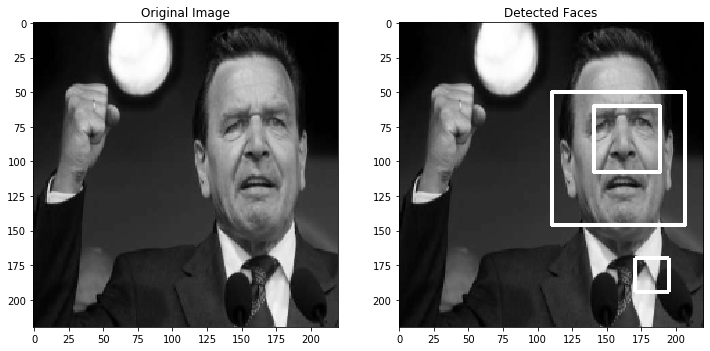

In [453]:
plot_results(test_im_3[0], detected_test_im_3[0])

# Few Problematic Cases

This could most likely be because of the absence of a diverse and sufficiently large training dataset. Some improvements that can be made to detect more accurately are as follows :

* Increase the dataset size - train with 10,000 images or so
* Include more diversity in the faces that are used for classification
* Add more number of classifiers - greater the num of classifiers, better the learning
* Include more non-face images to get rid of false postives

In [515]:
test_im_4 = np.copy(f_test_data[203])  
test_im_4[0] = cv2.resize(test_im_4[0], (130,130))
detected_test_im_4, num_test_im_4, anno_test_im_4 = detector.detect(test_im_4[0], test_im_4[1], 24)

100%|██████████| 13/13 [00:00<00:00, 39.32it/s]


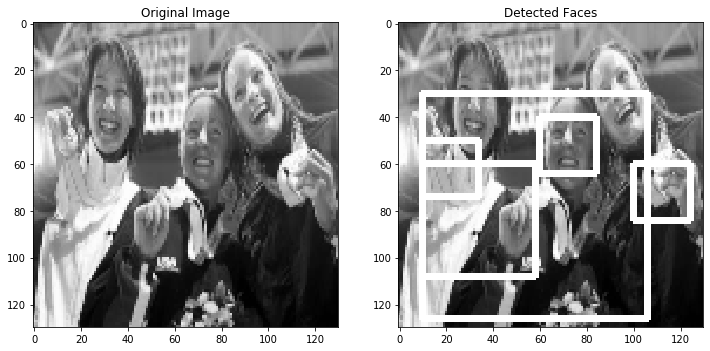

In [516]:
plot_results(test_im_4[0], detected_test_im_4[0])

In [609]:
test_im_5 = np.copy(f_test_data[213])  
test_im_5[0] = cv2.resize(test_im_5[0], (120,120))
detected_test_im_5, num_test_im_5, anno_test_im_5 = detector.detect(test_im_5[0], test_im_5[1], 24)

100%|██████████| 12/12 [00:00<00:00, 45.29it/s]


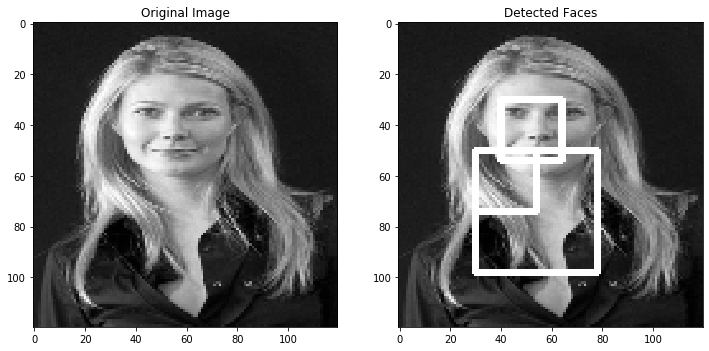

In [610]:
plot_results(test_im_5[0], detected_test_im_5[0])

In [656]:
test_im_7 = np.copy(f_test_data[29])
test_im_7[0] = cv2.resize(test_im_7[0], (130,130))
detected_test_im_7, num_test_im_7, anno_test_im_7 = detector.detect(test_im_7[0], test_im_7[1], 24)

100%|██████████| 13/13 [00:00<00:00, 37.56it/s]


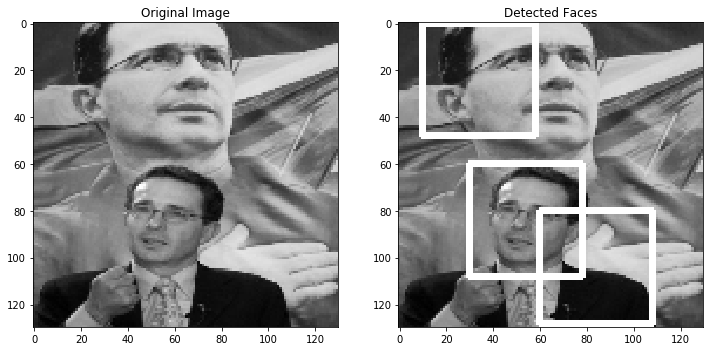

In [657]:
plot_results(test_im_7[0], detected_test_im_7[0])

In [681]:
test_im_8 = np.copy(f_test_data[97]) 
test_im_8[0] = cv2.resize(test_im_8[0], (220,220))
detected_test_im_8, num_test_im_8, anno_test_im_8 = detector.detect(test_im_8[0], test_im_8[1], 24)

100%|██████████| 22/22 [00:01<00:00, 15.66it/s]


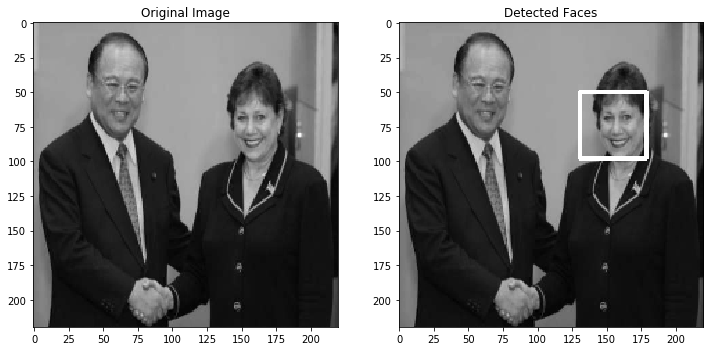

In [682]:
plot_results(test_im_8[0], detected_test_im_8[0])

# Testing Coloured Image

In [683]:
test_im_9 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/lady1.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_9.shape)
test_im_9 = cv2.resize(test_im_9, (140,140))
detected_test_im_9, num_test_im_9, anno_test_im_9 = detector.detect(test_im_9, 6, 24)


 21%|██▏       | 3/14 [00:00<00:00, 23.25it/s]

(336, 702, 3)


100%|██████████| 14/14 [00:00<00:00, 34.74it/s]


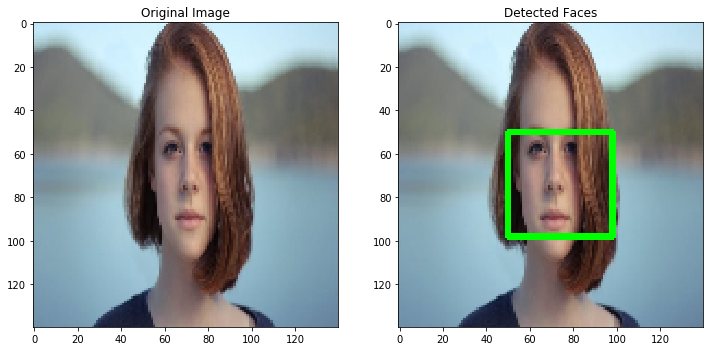

In [685]:
plot_results(test_im_9, detected_test_im_9[0])

In [686]:
test_im_10 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/girl.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_10.shape)
test_im_10 = cv2.resize(test_im_10, (110,110))
detected_test_im_10, num_test_im_10, anno_test_im_10 = detector.detect(test_im_10, 1, 24)

100%|██████████| 11/11 [00:00<00:00, 55.58it/s]

(417, 626, 3)


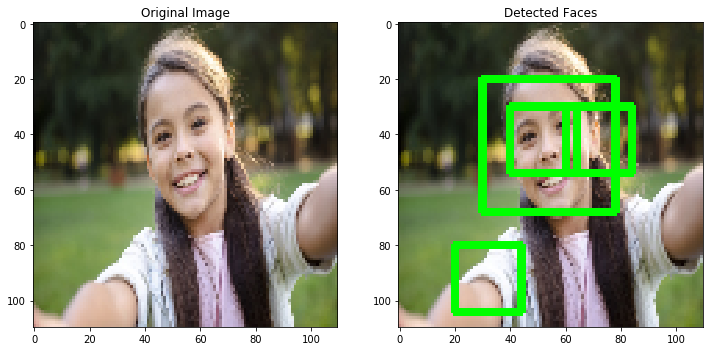

In [687]:
plot_results(test_im_10, detected_test_im_10[0])

In [724]:
test_im_11 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/titan.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_11.shape)
test_im_11 = cv2.resize(test_im_11, (140,140))
detected_test_im_11, num_test_im_11, anno_test_im_11 = detector.detect(test_im_11, 1, 24)

 14%|█▍        | 2/14 [00:00<00:00, 19.54it/s]

(1083, 2560, 3)


100%|██████████| 14/14 [00:00<00:00, 32.12it/s]


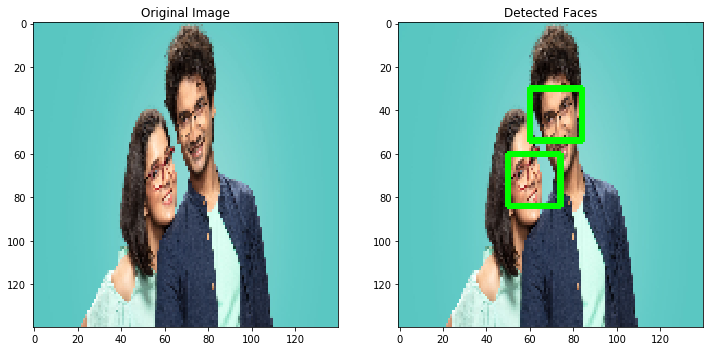

In [725]:
plot_results(test_im_11, detected_test_im_11[0])

In [816]:
test_im_12 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/amyjake.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_12.shape)
test_im_12 = cv2.resize(test_im_12, (160,160))
detected_test_im_12, num_test_im_12, anno_test_im_12 = detector.detect(test_im_12, 1, 55)

 31%|███▏      | 5/16 [00:00<00:00, 41.12it/s]

(417, 620, 3)


100%|██████████| 16/16 [00:00<00:00, 74.02it/s]


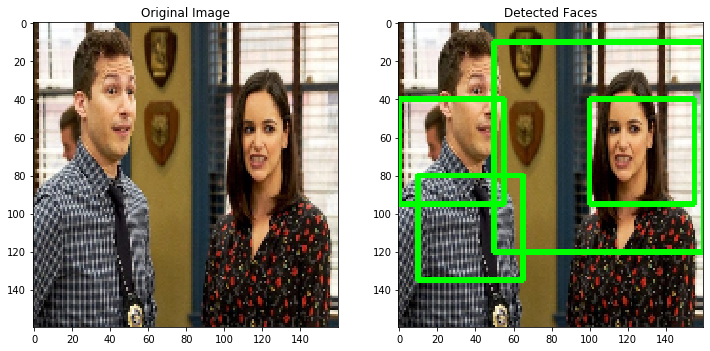

In [817]:
plot_results(test_im_12, detected_test_im_12[0])

In [842]:
test_im_13 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/girls.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_13.shape)
test_im_13 = cv2.resize(test_im_13, (140,140))
detected_test_im_13, num_test_im_13, anno_test_im_13 = detector.detect(test_im_13, 1, 48)

100%|██████████| 14/14 [00:00<00:00, 78.63it/s]

(629, 1200, 3)


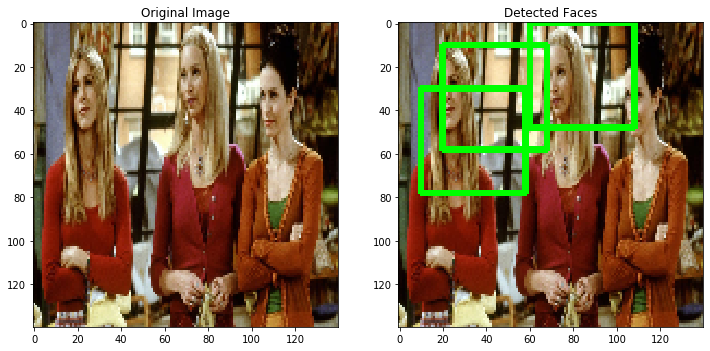

In [843]:
plot_results(test_im_13, detected_test_im_13[0])

In [887]:
test_im_14 = cv2.cvtColor(cv2.imread("../dataset/custom_test_data/sherlock2.jpg"), cv2.COLOR_BGR2RGB)
print(test_im_14.shape)
test_im_14 = cv2.resize(test_im_14, (250,250))
detected_test_im_14, num_test_im_14, anno_test_im_14 = detector.detect(test_im_14, 1, 36)

  8%|▊         | 2/25 [00:00<00:01, 14.14it/s]

(1080, 1920, 3)


100%|██████████| 25/25 [00:01<00:00, 19.52it/s]


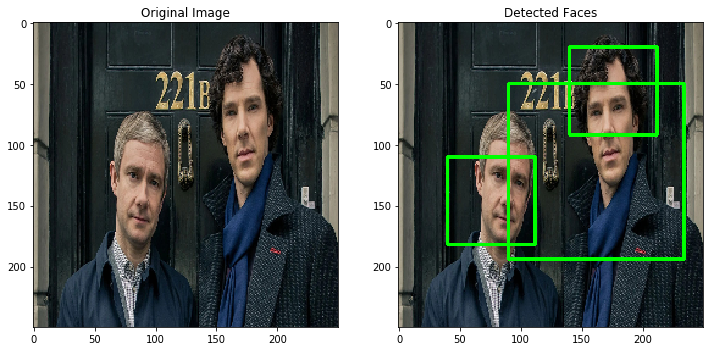

In [888]:
plot_results(test_im_14, detected_test_im_14[0])